<a href="https://colab.research.google.com/github/akhilvjose/TrafficSignClassification/blob/master/GermanTraffic_sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install wget

In [0]:
import wget
import zipfile

In [0]:
wget.download("https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip")

'traffic-signs-data.zip'

In [0]:
with zipfile.ZipFile('traffic-signs-data.zip', 'r') as zip_ref:
  zip_ref.extractall('Traffic_data')

In [0]:
!ls Traffic_data

test.p	train.p  valid.p


## Project: Build a Traffic Sign Recognition Classifier

In [0]:
import pickle
import random 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from scipy.misc import imread, imsave, imresize
import warnings
from skimage import exposure

## Step 0: Load The Data

In [0]:
# Load pickled data

training_file = "Traffic_data/train.p"
validation_file="Traffic_data/valid.p"
testing_file = "Traffic_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_valid:",X_valid.shape)
print("y_valid:",y_valid.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

X_train: (34799, 32, 32, 3)
y_train: (34799,)
X_valid: (4410, 32, 32, 3)
y_valid: (4410,)
X_test: (12630, 32, 32, 3)
y_test: (12630,)


## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [0]:
### Use python, pandas or numpy methods rather than hard coding the results

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1],X_train.shape[2],X_train.shape[3]

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?


#### use if you have the csv file
label_data=pd.read_csv('signnames.csv') 

print (label_data)


10


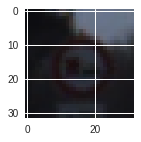

In [0]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print(y_train[index])

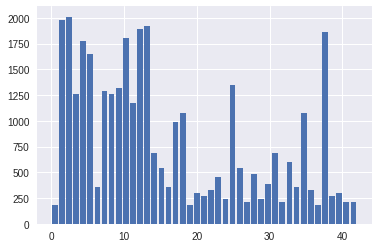

In [0]:
hist, bins = np.histogram(y_train, bins=n_classes)
width =  0.8*(bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)
Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, (pixel - 128)/ 128 is a quick way to approximately normalize the data and can be used in this project.

Other pre-processing steps are optional. You can try different techniques to see if it improves performance.

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [0]:
def preprocess(Image):
    #Convert to grayscale, e.g. single channel Y
    Image = 0.299 * Image[:, :, :, 0] + 0.587 * Image[:, :, :, 1] + 0.114 * Image[:, :, :, 2]

    #Scale features to be in [0, 1]
    Image = (Image / 255.).astype(np.float32)
    
    #adjust histogram
    for i in range(Image.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            Image[i] = exposure.equalize_adapthist(Image[i]) 
            
    return Image

def reshape(Img): # Add a single grayscale channel
    return Img.reshape(Img.shape + (1,))

In [0]:
#Time Consuming due to the histogram step. Run only if it is unavoidable.
# Processed data is available in pickle file below

print("Processing....")

Pre_X_train = preprocess(X_train)
X_train_preprocessed = reshape(Pre_X_train)
print("preprocessed X_train shape:", X_train_preprocessed.shape)

Pre_X_valid = preprocess(X_valid)
X_valid_preprocessed = reshape(Pre_X_valid)
print("preprocessed X_valid shape:", X_valid_preprocessed.shape)

Pre_X_test = preprocess(X_test)
X_test_preprocessed = reshape(Pre_X_test)
print("preprocessed X_test shape:", X_test_preprocessed.shape)

Processing....
preprocessed X_train shape: (34799, 32, 32, 1)
preprocessed X_valid shape: (4410, 32, 32, 1)
preprocessed X_test shape: (12630, 32, 32, 1)


In [0]:
# Preprocessed images are saved in pickle file to save time

pickle.dump(X_train_preprocessed, open('training_preprocessed_file.p', "wb" ))
pickle.dump(X_valid_preprocessed, open('validation_preprocessed_file.p', "wb" ))
pickle.dump(X_test_preprocessed, open('testing_preprocessed_file.p', "wb" ))

In [0]:
with open("training_preprocessed_file.p", mode='rb') as f:
    X_train_preprocessed = pickle.load(f)
with open("validation_preprocessed_file.p", mode='rb') as f:
    X_valid_preprocessed = pickle.load(f)
with open("testing_preprocessed_file.p", mode='rb') as f:
    X_test_preprocessed = pickle.load(f)

## Model Architecture

In [0]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
#mu = 0
#sigma = 0.1
    
# SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
#conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 60), mean = mu, stddev = sigma))
#conv1_b = tf.Variable(tf.zeros(60))
#conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

weights={
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 64), mean = 0, stddev = 0.1)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 32), mean = 0, stddev = 0.1)),
    'wd1':tf.Variable(tf.truncated_normal(shape=(8*8*32, 256), mean = 0, stddev = 0.1)),
    'Wout': tf.Variable(tf.truncated_normal(shape=(256, 43), mean = 0, stddev = 0.1))
}

biases = {
    'bc1': tf.Variable(tf.zeros([64])),
    'bc2': tf.Variable(tf.zeros([32])),
    'bd1': tf.Variable(tf.zeros([256])),
    'bout': tf.Variable(tf.zeros([43]))
}

In [0]:

from tensorflow.contrib.layers import flatten

def conv2d(x, weights, biases):
    conv = tf.nn.conv2d(x, weights, strides = [1, 1, 1, 1], padding = 'SAME')
    conv = tf.nn.bias_add(conv, biases)
    conv=tf.nn.relu(conv)
    conv=tf.nn.max_pool(conv,ksize=[1,2,2,1],strides=[1,2,2,1],padding = 'SAME')
    return conv

#def leaky_relu(X):
   # return tf.maximum(0.01*X,X)
def conv_net (X, weights, biases,keep_prob):
    
    conv1=conv2d(X,weights['wc1'],biases['bc1']) 
    
    conv2=conv2d(conv1,weights['wc2'],biases['bc2'])
    
    
    fc1=flatten(conv2)
    #fc1=tf.reshape(conv2,[-1,weights['wd1'].get_shape().as_list()[0]])
    fc1=tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1=tf.nn.relu(fc1)
    fc1=tf.nn.dropout(fc1, keep_prob)
    
    out=tf.add(tf.matmul(fc1, weights['Wout']), biases['bout'])
    out=tf.nn.dropout(out, keep_prob)
    return out



### Train, Validate and Test the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [0]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
rate = 0.0005
EPOCHS = 75     
BATCH_SIZE = 256
n_classes=43
num_Xtrain = 34799 #len(X_train_preprocessed)

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits = conv_net(x,weights,biases,keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
def evaluate(X_data, y_data):
    
    total_accuracy = 0
    num_Xtrain = len(X_data)
    sess = tf.get_default_session()
    
    for offset in range(0, num_Xtrain, BATCH_SIZE):  
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict= {x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / num_Xtrain

In [0]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    print ("Training......")
    for epoch in range(EPOCHS):
        
        X_data, y_data = shuffle(X_train_preprocessed, y_train)
        
        for offset in range(0, num_Xtrain, BATCH_SIZE):
            #end = start + BATCH_SIZE
            batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
            
            _, loss = sess.run([training_operation, loss_operation], feed_dict = {x: batch_x, y: batch_y, keep_prob: 0.75})
            
        validation_accuracy = evaluate(X_valid_preprocessed, y_valid)
        
        print("EPOCH {} ...".format(epoch+1))
        print("Validation Acc = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './model')
    print("Model saved")

Training......
EPOCH 1 ...
Validation Acc = 0.576
EPOCH 2 ...
Validation Acc = 0.790
EPOCH 3 ...
Validation Acc = 0.848
EPOCH 4 ...
Validation Acc = 0.887
EPOCH 5 ...
Validation Acc = 0.913
EPOCH 6 ...
Validation Acc = 0.916
EPOCH 7 ...
Validation Acc = 0.935
EPOCH 8 ...
Validation Acc = 0.939
EPOCH 9 ...
Validation Acc = 0.945
EPOCH 10 ...
Validation Acc = 0.946
EPOCH 11 ...
Validation Acc = 0.952
EPOCH 12 ...
Validation Acc = 0.956
EPOCH 13 ...
Validation Acc = 0.951
EPOCH 14 ...
Validation Acc = 0.955
EPOCH 15 ...
Validation Acc = 0.956
EPOCH 16 ...
Validation Acc = 0.958
EPOCH 17 ...
Validation Acc = 0.954
EPOCH 18 ...
Validation Acc = 0.958
EPOCH 19 ...
Validation Acc = 0.959
EPOCH 20 ...
Validation Acc = 0.961
EPOCH 21 ...
Validation Acc = 0.961
EPOCH 22 ...
Validation Acc = 0.961
EPOCH 23 ...
Validation Acc = 0.963
EPOCH 24 ...
Validation Acc = 0.965
EPOCH 25 ...
Validation Acc = 0.962
EPOCH 26 ...
Validation Acc = 0.963
EPOCH 27 ...
Validation Acc = 0.967
EPOCH 28 ...
Validatio

In [0]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model
Test Accuracy = 0.963
